## Model

In [664]:
## For Model
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import math
from scipy.stats import shapiro
from pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit




[*********************100%***********************]  2 of 2 completed


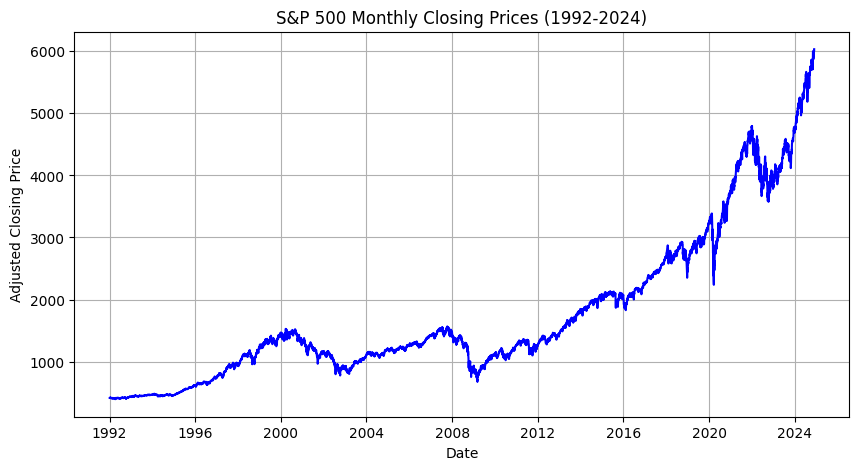

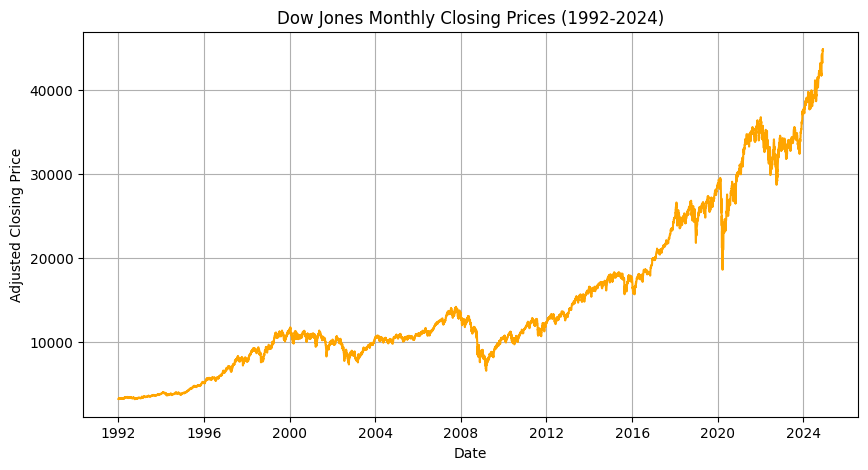

In [665]:
# S&P 500 and Dow Jones data from Yahoo Finance
# Stock Market Data

start_date = '1992-01-02'

tickers = ["^GSPC", "^DJI"]
stock_market_data = yf.download(
    tickers, start=start_date, 
    end="2024-12-01",
    interval="1d"
)

sp500_data = stock_market_data["Adj Close"]["^GSPC"]

dowjones_data = stock_market_data["Adj Close"]["^DJI"]

dowjones_data = dowjones_data.dropna()

# Plot for S&P 500
plt.figure(figsize=(10, 5))
plt.plot(sp500_data.index, sp500_data, color="blue")
plt.title("S&P 500 Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()

# Plot for Dow Jones
plt.figure(figsize=(10, 5))
plt.plot(dowjones_data.index, dowjones_data, color="orange")
plt.title("Dow Jones Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()

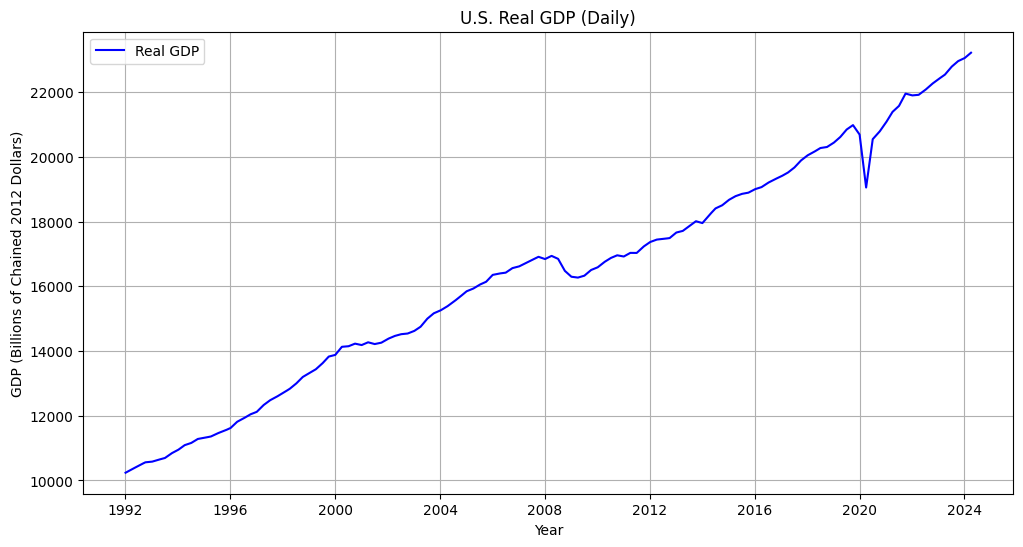

In [666]:
# GDP data from FRED
gdp_data = pd.read_csv("gdp_data_1965_2024.csv")
gdp_data.rename(columns={
    "Unnamed: 0": "date"
}, inplace=True)
gdp_data['date'] = pd.to_datetime(gdp_data['date'])

gdp_data.set_index("date", inplace=True)

daily_index = pd.date_range(
    start=gdp_data.index.min(), 
    end=gdp_data.index.max(), 
    freq='D'
)

gdp_data_daily = gdp_data.reindex(daily_index)

gdp_data_daily['Real GDP'] = gdp_data_daily['Real GDP'].interpolate(method='linear')

gdp_data_daily = gdp_data_daily.loc[start_date:]

# Plot for GDP
plt.figure(figsize=(12, 6))
plt.plot(
    gdp_data_daily.index,
    gdp_data_daily["Real GDP"],
    color="blue",
    label="Real GDP",
)
plt.title("U.S. Real GDP (Daily)")
plt.xlabel("Year")
plt.ylabel("GDP (Billions of Chained 2012 Dollars)")
plt.grid()
plt.legend()
plt.show()


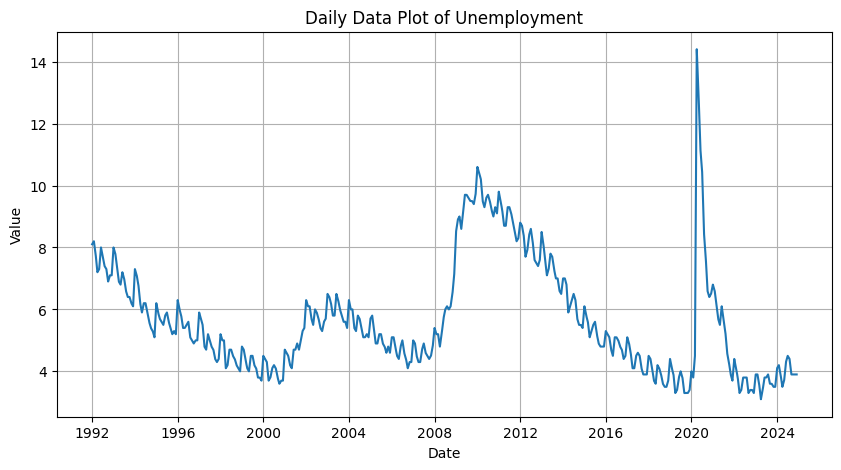

In [667]:
# Unemployment Data
unemployment_data = pd.read_csv("unemployment_data.csv")

unemployment_data_long = unemployment_data.melt(
    id_vars=["Year"], var_name="Month", value_name="Value"
)

unemployment_data_long["Month"] = pd.to_datetime(
    unemployment_data_long["Month"], format="%b"
).dt.month

unemployment_data_long["Date"] = pd.to_datetime(
    unemployment_data_long[["Year", "Month"]].assign(Day=1)
)

unemployment_data_long = unemployment_data_long.sort_values("Date")

unemployment_data_long.set_index("Date", inplace=True)

daily_index = pd.date_range(
    start=unemployment_data_long.index.min(), 
    end="2024-12-01", 
    freq='D')

unemployment_data_daily = unemployment_data_long.reindex(daily_index)

unemployment_data_daily = unemployment_data_daily.interpolate(method='linear')

unemployment_data_daily = unemployment_data_daily.loc[start_date:]

unemployment_data_daily.index.name = 'Date'

# Plot for unemployment rate
plt.figure(figsize=(10, 5))
plt.plot(unemployment_data_daily.index, unemployment_data_daily["Value"])
plt.title("Daily Data Plot of Unemployment")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.show()

              Year  Month       CPI
Date                               
1992-01-02  1992.0    1.0  3.896774
1992-01-03  1992.0    1.0  3.893548
1992-01-04  1992.0    1.0  3.890323
1992-01-05  1992.0    1.0  3.887097
1992-01-06  1992.0    1.0  3.883871
...            ...    ...       ...
2024-11-27  2024.0   11.0  3.300000
2024-11-28  2024.0   11.0  3.300000
2024-11-29  2024.0   11.0  3.300000
2024-11-30  2024.0   11.0  3.300000
2024-12-01  2024.0   12.0  3.300000

[12023 rows x 3 columns]


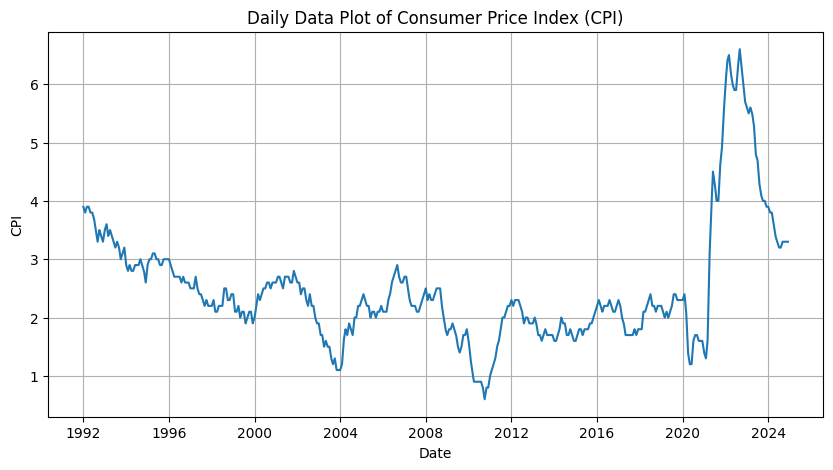

In [668]:
# CPI Data
cpi_data = pd.read_csv("cpi_data.csv")
cpi_data.drop(columns=["HALF1", "HALF2"], inplace=True)
cpi_data_long = cpi_data.melt(id_vars=["Year"], var_name="Month", value_name="CPI")
cpi_data_long["Month"] = pd.to_datetime(cpi_data_long["Month"], format="%b").dt.month
cpi_data_long["Date"] = pd.to_datetime(cpi_data_long[["Year", "Month"]].assign(Day=1))
cpi_data_long = cpi_data_long.sort_values("Date")

daily_index = pd.date_range(start=cpi_data_long['Date'].min(), 
                            end=cpi_data_long['Date'].max(), 
                            freq='D')

cpi_data_daily = cpi_data_long.set_index('Date').reindex(daily_index)

cpi_data_daily['CPI'] = cpi_data_daily['CPI'].interpolate(method='linear')
cpi_data_daily['Year'] = cpi_data_daily['Year'].fillna(method="ffill")
cpi_data_daily['Month'] = cpi_data_daily['Month'].fillna(method="ffill")

cpi_data_daily.index.name = 'Date'

cpi_data_daily = cpi_data_daily.loc[start_date:]
print(cpi_data_daily)

#loc[start_date:]

# Plot for CPI
plt.figure(figsize=(10, 5))
plt.plot(cpi_data_daily.index, cpi_data_daily["CPI"])
plt.title("Daily Data Plot of Consumer Price Index (CPI)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid()
plt.show()

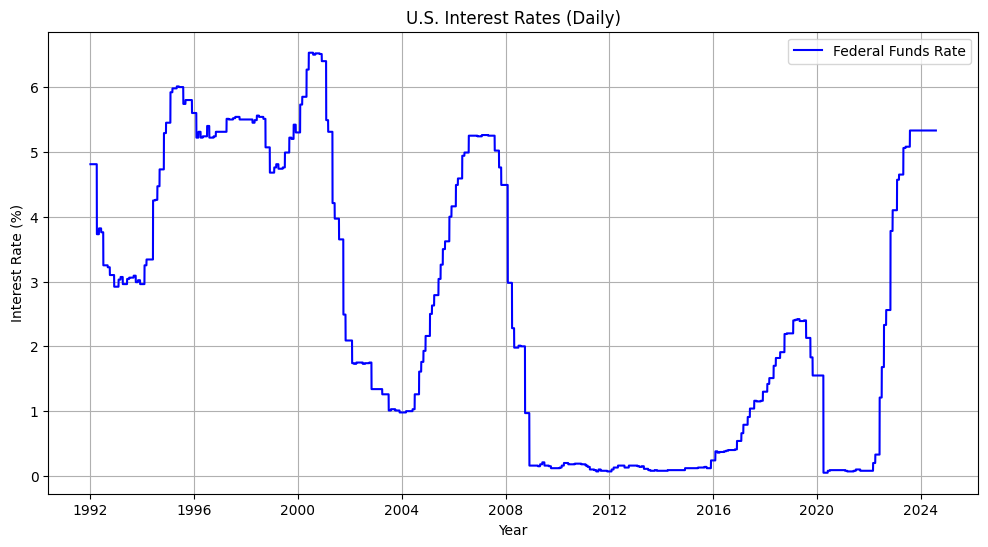

In [701]:
# Interest Rates Data
interest_rates_df = pd.read_csv(
    "interest_rates_1965_2024.csv", index_col=0, parse_dates=True
)

interest_rates_df = interest_rates_df.dropna()

daily_index = pd.date_range(start=interest_rates_df.index.min(), 
                            end=interest_rates_df.index.max(), 
                            freq='D')

interest_rates_daily = interest_rates_df.reindex(daily_index)

interest_rates_daily = interest_rates_daily.fillna(method='ffill')

interest_rates_daily.index.name = 'Date'

interest_rates_daily = interest_rates_daily.loc[start_date:]

# Plot for Interest Rates
plt.figure(figsize=(12, 6))
plt.plot(
    interest_rates_daily.index,
    interest_rates_daily["Federal Funds Rate"],
    label="Federal Funds Rate",
    color="blue",
)
plt.title("U.S. Interest Rates (Daily)")
plt.xlabel("Year")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.grid()
plt.show()

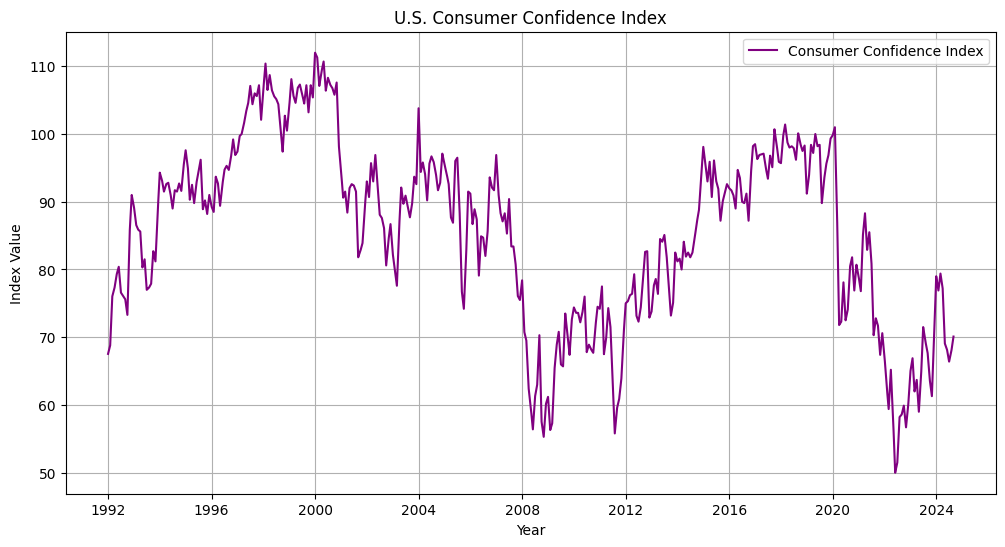

In [670]:
# Consumer Confidence Index Data
consumer_confidence_df = pd.read_csv(
    "consumer_confidence_index_1965_2024.csv", index_col=0, parse_dates=True
)

consumer_confidence_df = consumer_confidence_df.interpolate(method="linear")

daily_index = pd.date_range(start=consumer_confidence_df.index.min(), 
                            end=consumer_confidence_df.index.max(), 
                            freq='D')

consumer_confidence_daily = consumer_confidence_df.reindex(daily_index)

consumer_confidence_daily = consumer_confidence_daily.interpolate(method="linear")

consumer_confidence_daily.index.name = 'Date'

consumer_confidence_daily = consumer_confidence_daily.loc[start_date:]

# print(consumer_confidence_daily)

# Plot for Consumer Confidence Index
plt.figure(figsize=(12, 6))
plt.plot(
    consumer_confidence_daily.index,
    consumer_confidence_daily["Consumer Confidence Index"],
    color="purple",
    label="Consumer Confidence Index",
)
plt.title("U.S. Consumer Confidence Index")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.grid()
plt.legend()
plt.show()

In [671]:

sp500_data.index = sp500_data.index.tz_localize(None)
dowjones_data.index = dowjones_data.index.tz_localize(None)

combined_exogenous_data = pd.DataFrame({
    'GDP': gdp_data_daily['Real GDP'],
    'Unemployment Rate': unemployment_data_daily['Value'],
    'CPI': cpi_data_daily['CPI'],
    'Interest Rates': interest_rates_daily['Federal Funds Rate'],
    'Consumer Confidence Index': consumer_confidence_daily['Consumer Confidence Index']
})

combined_exogenous_data = combined_exogenous_data.reindex(sp500_data.index)

combined_exogenous_data["GDP"] = combined_exogenous_data["GDP"].interpolate(method="linear")
combined_exogenous_data["Unemployment Rate"] = combined_exogenous_data["Unemployment Rate"].fillna(method="ffill")
combined_exogenous_data["CPI"] = combined_exogenous_data["CPI"].fillna(method="ffill")
combined_exogenous_data["Interest Rates"] = combined_exogenous_data["Interest Rates"].fillna(method="ffill")
combined_exogenous_data["Consumer Confidence Index"] = combined_exogenous_data["Consumer Confidence Index"].interpolate(method="linear")


In [672]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dft")
    adft = adfuller(timeseries,autolag='AIC')
    # output for test
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

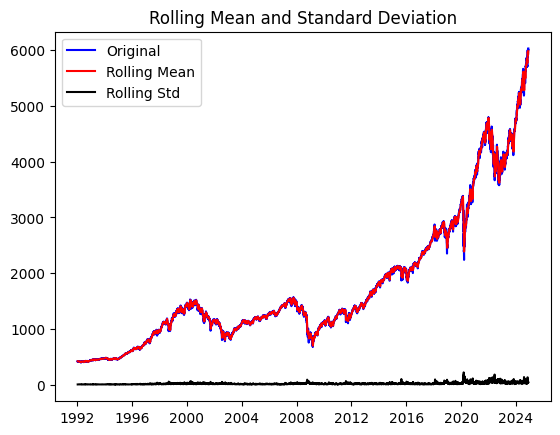

Results of dft
Test Statistics                   3.208697
p-value                           1.000000
No. of lags used                 30.000000
Number of observations used    8259.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


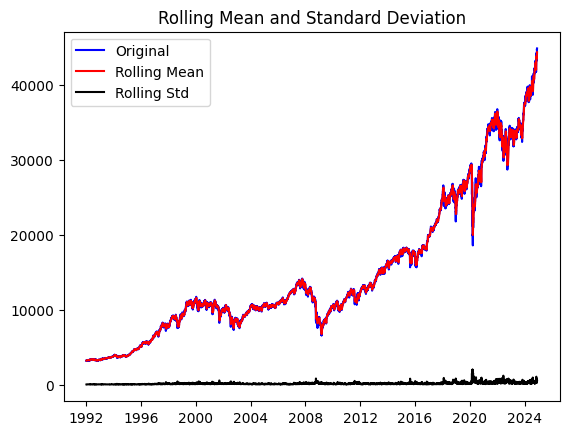

Results of dft
Test Statistics                   2.249609
p-value                           0.998921
No. of lags used                 31.000000
Number of observations used    8258.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


In [673]:
test_stationarity(sp500_data)
test_stationarity(dowjones_data)

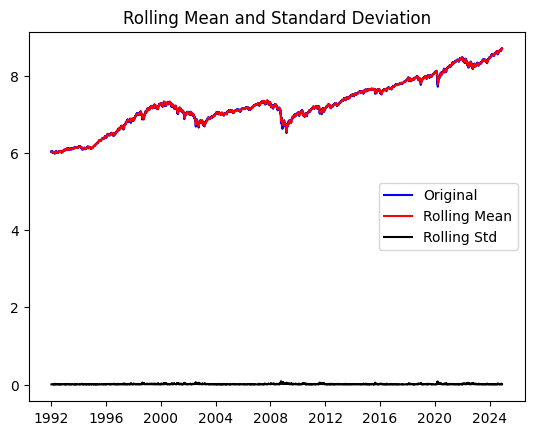

Results of dft
Test Statistics                  -0.135832
p-value                           0.945750
No. of lags used                 34.000000
Number of observations used    8255.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


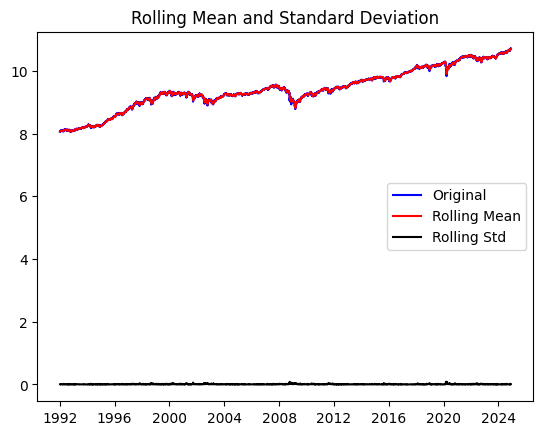

Results of dft
Test Statistics                  -0.678320
p-value                           0.852286
No. of lags used                 34.000000
Number of observations used    8255.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


In [674]:
sp500_data = np.log(sp500_data)
dowjones_data = np.log(dowjones_data)
test_stationarity(sp500_data)
test_stationarity(dowjones_data)


 GDP 



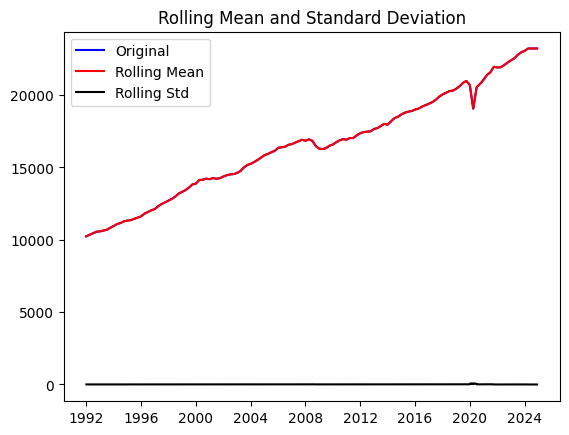

Results of dft
Test Statistics                  -0.036741
p-value                           0.955386
No. of lags used                 37.000000
Number of observations used    8252.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 Unemployment Rate 



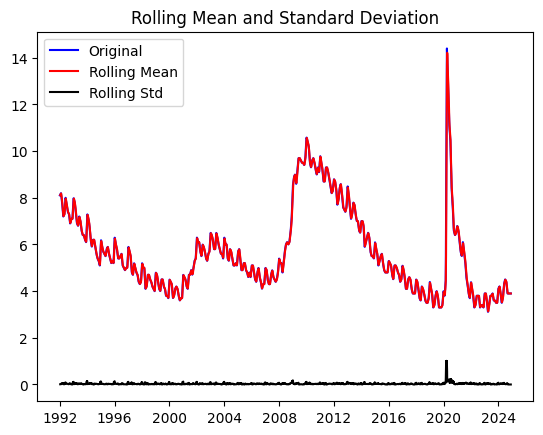

Results of dft
Test Statistics                  -3.229455
p-value                           0.018342
No. of lags used                 37.000000
Number of observations used    8252.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 CPI 



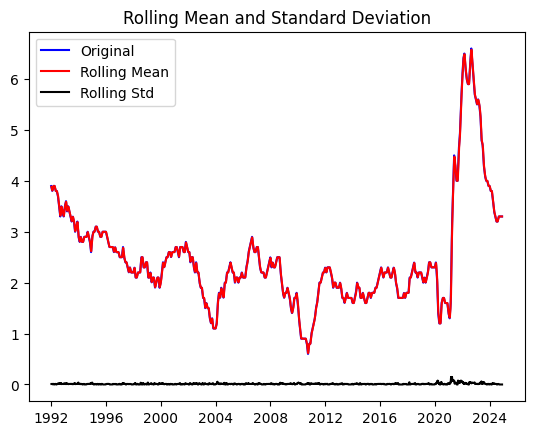

Results of dft
Test Statistics                  -2.711981
p-value                           0.071988
No. of lags used                 28.000000
Number of observations used    8261.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 Interest Rates 



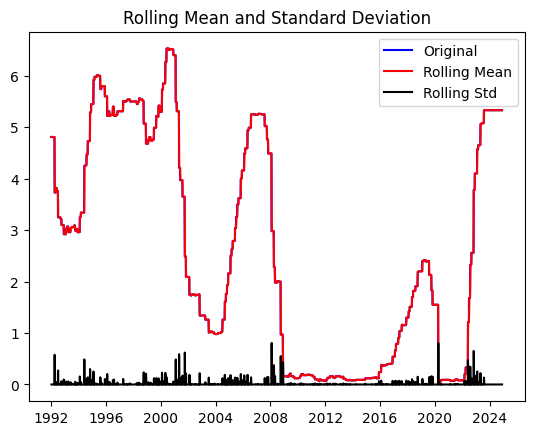

Results of dft
Test Statistics                  -1.110494
p-value                           0.710869
No. of lags used                 23.000000
Number of observations used    8266.000000
critical value (1%)              -3.431141
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64

 Consumer Confidence Index 



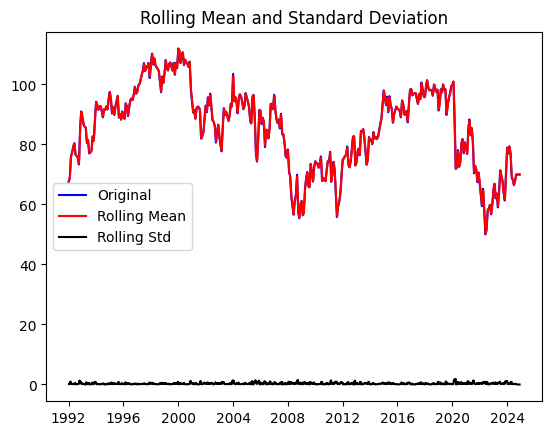

Results of dft
Test Statistics                  -2.344382
p-value                           0.158053
No. of lags used                 37.000000
Number of observations used    8252.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


In [675]:
# combined_exogenous_data_diff = combined_exogenous_data

for column in combined_exogenous_data.columns:
    print("\n",column, "\n")
    test_stationarity(combined_exogenous_data[column])

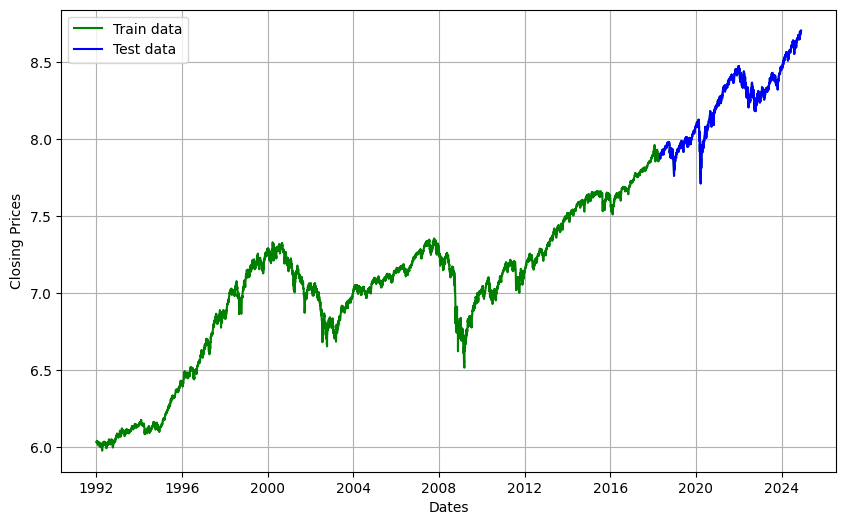

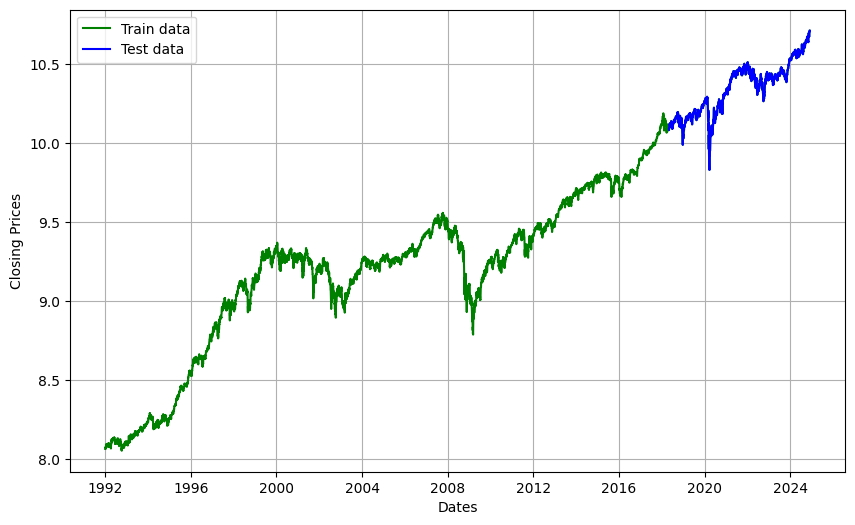

In [676]:
train_size = int(len(sp500_data) * 0.8)
train_sp500, test_sp500 = sp500_data[:train_size], sp500_data[train_size:]
train_dowjones, test_dowjones = dowjones_data[:train_size], dowjones_data[train_size:]
train_exog, test_exog = combined_exogenous_data[:train_size], combined_exogenous_data[train_size:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(sp500_data, 'green', label='Train data')
plt.plot(test_sp500, 'blue', label='Test data')
plt.legend()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(dowjones_data, 'green', label='Train data')
plt.plot(test_dowjones, 'blue', label='Test data')
plt.legend()


In [677]:
# Auto ARIMA with selected exogenous variables
auto_model = auto_arima(
    train_sp500,
    exogenous=train_exog,
    seasonal=False,
    d=None,  # Let auto_arima determine differencing
    trace=True,
    
)

auto_model = auto_arima(
    train_dowjones,
    exogenous=train_exog,
    seasonal=False,
    d=None,  # Let auto_arima determine differencing
    trace=True,
    
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-40772.231, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40738.886, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-40762.226, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-40764.820, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40736.789, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-40775.045, Time=1.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-40777.106, Time=1.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-40775.057, Time=3.69 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-40775.348, Time=0.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-40772.677, Time=1.76 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-40773.885, Time=0.65 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 15.347 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-41436.129, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)

In [678]:
sarimax_model_sp500 = SARIMAX(
    train_sp500,
    exog=train_exog,
    order=(0,1,2),
)

results_sp500 = sarimax_model_sp500.fit()

print("S&P 500 Model Summary:")
print(results_sp500.summary())

sarimax_model_dowjones = SARIMAX(
    train_dowjones,
    exog=train_exog,
    order=(3,1,3),
)

results_dowjones = sarimax_model_dowjones.fit()

print("Dow Jones Model Summary:")
print(results_dowjones.summary())



S&P 500 Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 6632
Model:               SARIMAX(0, 1, 2)   Log Likelihood               20405.639
Date:                Sun, 08 Dec 2024   AIC                         -40795.278
Time:                        22:32:18   BIC                         -40740.882
Sample:                             0   HQIC                        -40776.483
                               - 6632                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
GDP                           0.0002   4.93e-05      4.648      0.000       0.000       0.000
Unemployment Rate             0.0033      0.006      0.530     

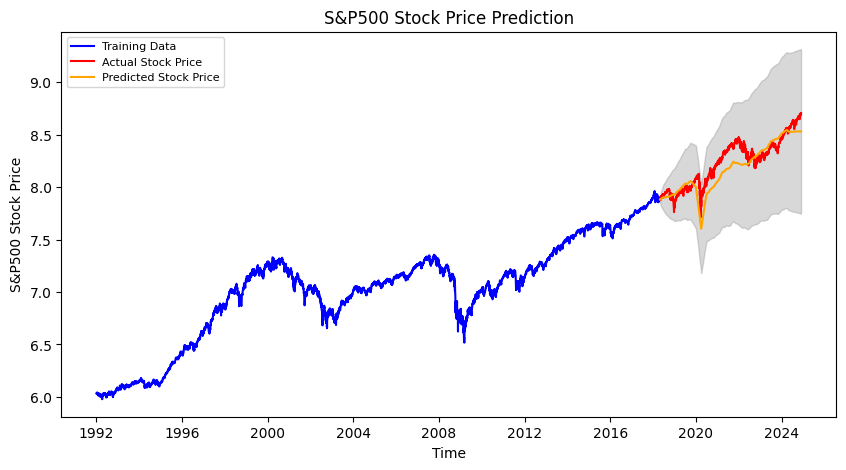

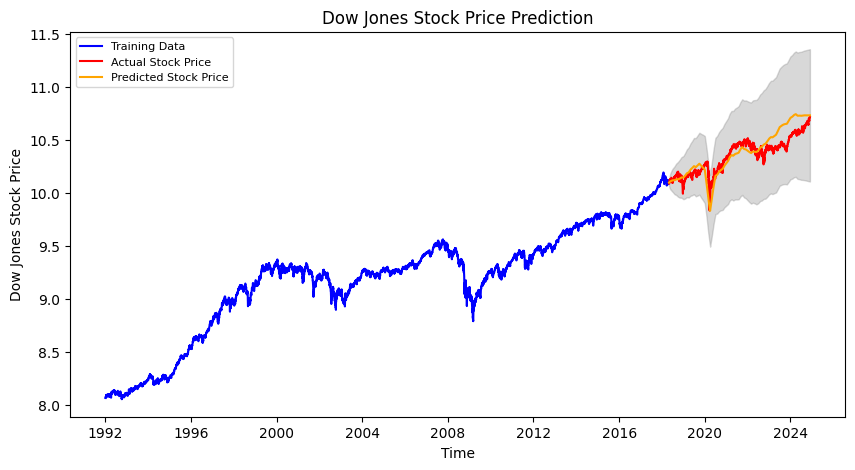

In [679]:

# Forecast
forecast = results_sp500.get_forecast(steps=len(test_sp500), exog=test_exog, alpha=0.05)

# Extract predicted mean and confidence intervals
fc_sp500 = forecast.predicted_mean
conf_sp500 = forecast.conf_int()



# Align indices
fc_sp500.index = test_sp500.index
conf_sp500.index = test_sp500.index

# Convert to pandas series
fc_series = pd.Series(fc_sp500, index=test_sp500.index)
lower_series = pd.Series(conf_sp500.iloc[:, 0], index=test_sp500.index)
upper_series = pd.Series(conf_sp500.iloc[:, 1], index=test_sp500.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_sp500, label='Training Data', color='blue')
plt.plot(test_sp500, label='Actual Stock Price', color='red')
plt.plot(fc_series, label='Predicted Stock Price', color='orange')
plt.fill_between(lower_series.index, lower_series, upper_series, color='gray', alpha=0.3)
plt.title('S&P500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P500 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


# Forecast
forecast = results_dowjones.get_forecast(steps=len(test_dowjones), exog=test_exog, alpha=0.05)

# Extract predicted mean and confidence intervals
fc_dowjones = forecast.predicted_mean
conf_dowjones = forecast.conf_int()

# Align indices
fc_dowjones.index = test_dowjones.index
conf_dowjones.index = test_dowjones.index

# Convert to pandas series
fc_series = pd.Series(fc_dowjones, index=test_dowjones.index)
lower_series = pd.Series(conf_dowjones.iloc[:, 0], index=test_dowjones.index)
upper_series = pd.Series(conf_dowjones.iloc[:, 1], index=test_dowjones.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_dowjones, label='Training Data', color='blue')
plt.plot(test_dowjones, label='Actual Stock Price', color='red')
plt.plot(fc_series, label='Predicted Stock Price', color='orange')
plt.fill_between(lower_series.index, lower_series, upper_series, color='gray', alpha=0.3)
plt.title('Dow Jones Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Dow Jones Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [680]:

mae_sp500 = mean_absolute_error(test_sp500, fc_sp500)
mse_sp500 = mean_squared_error(test_sp500, fc_sp500)
rmse_sp500 = np.sqrt(mse_sp500)
print(f"S&P 500 - MAE: {mae_sp500}, MSE: {mse_sp500}, RMSE: {rmse_sp500}")

mae_dow = mean_absolute_error(test_dowjones, fc_dowjones)
mse_dow = mean_squared_error(test_dowjones, fc_dowjones)
rmse_dow = np.sqrt(mse_dow)
print(f"Dow Jones - MAE: {mae_dow}, MSE: {mse_dow}, RMSE: {rmse_dow}")


S&P 500 - MAE: 0.0981331363021988, MSE: 0.014929442523914004, RMSE: 0.12218609791590042
Dow Jones - MAE: 0.08502018818144061, MSE: 0.010846896621197972, RMSE: 0.10414843551968495


In [737]:
def cross_validate(endog, exog, order=(1,1,1)):
    # Define time-series cross-validator
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Store results
    mae_list = []  # List to store Mean Absolute Error (MAE) for each fold

    # Loop through splits
    for train_index, test_index in tscv.split(endog):

        # Split data into train and test sets
        train_endog, test_endog = endog.iloc[train_index], endog.iloc[test_index]
        train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]

        # Train ARIMAX model
        model = SARIMAX(train_endog, exog=train_exog, order=order)
        results = model.fit(disp=False)

        # Forecast on test data
        forecast = results.get_forecast(steps=len(test_endog), exog=test_exog)
        predictions = forecast.predicted_mean
        predictions.index = test_endog.index

        # Calculate MAE
        mae = np.mean(np.abs(predictions - test_endog))
        mae_list.append(mae)

    # Cross-validation results
    print("Cross-validated MAE scores:", mae_list)
    print("Average MAE:", np.mean(mae_list))


cross_validate(sp500_data, combined_exogenous_data, (0,1,2))
cross_validate(dowjones_data, combined_exogenous_data, (3,1,3))


Cross-validated MAE scores: [0.17376165448357478, 0.11527708383732169, 0.16901981287741305, 0.149711024315945, 0.18027668990235263]
Average MAE: 0.15760925308332144
Cross-validated MAE scores: [0.288701877840795, 0.04068143007282482, 0.16558159218224783, 0.1497777850329824, 0.10075967719802296]
Average MAE: 0.14910047246537458


In [713]:
future_steps = 252 

last_date = pd.to_datetime("2024-11-29")

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

future_exog = combined_exogenous_data.reindex(combined_exogenous_data.index.union(future_dates))

future_exog["GDP"] = future_exog["GDP"].interpolate(method="linear")
future_exog["Unemployment Rate"] = future_exog["Unemployment Rate"].fillna(method="ffill")
future_exog["CPI"] = future_exog["CPI"].fillna(method="ffill")
future_exog["Interest Rates"] = future_exog["Interest Rates"].fillna(method="ffill")
future_exog["Consumer Confidence Index"] = future_exog["Consumer Confidence Index"].interpolate(method="linear")

future_exog = future_exog[last_date + pd.Timedelta(days=1):]


In [708]:
full_sp500 = pd.concat([train_sp500, test_sp500])
full_dowjones = pd.concat([train_dowjones, test_dowjones])
full_exog = pd.concat([train_exog, test_exog])

future_sp500_model = SARIMAX(full_sp500, exog=full_exog, order=(0, 1, 2))  # Adjust order based on your best model
future_sp500_results = future_sp500_model.fit()

future_dowjones_model = SARIMAX(full_dowjones, exog=full_exog, order=(3, 1, 3))  # Adjust order based on your best model
future_dowjones_results = future_dowjones_model.fit()




In [717]:
# Forecast S&P 500

forecast_sp500 = future_sp500_results.get_forecast(steps=future_steps, exog=future_exog)
predicted_sp500 = forecast_sp500.predicted_mean
conf_int_sp500 = forecast_sp500.conf_int()

# Forecast Dow Jones
forecast_dow = future_dowjones_results.get_forecast(steps=future_steps, exog=future_exog)
predicted_dow = forecast_dow.predicted_mean
conf_int_dow = forecast_dow.conf_int()

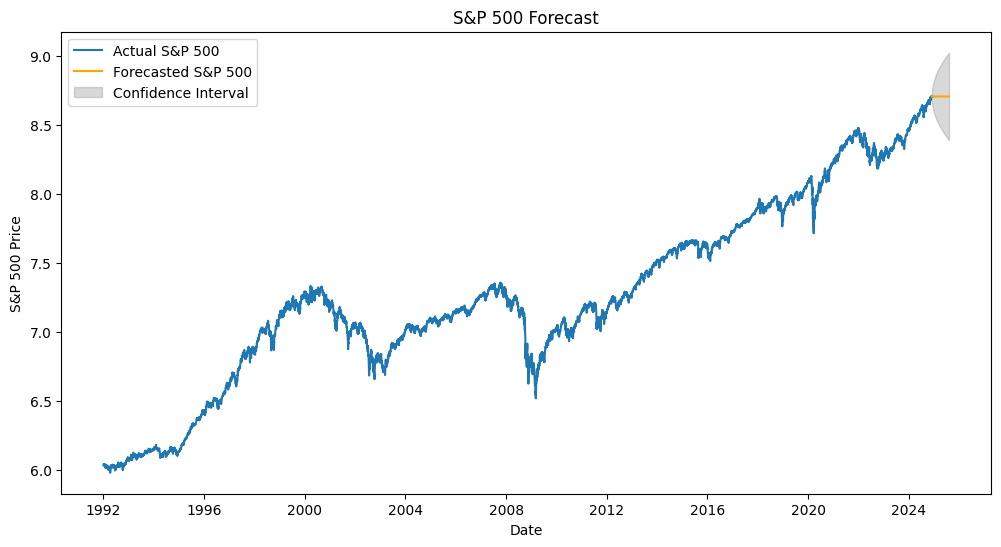

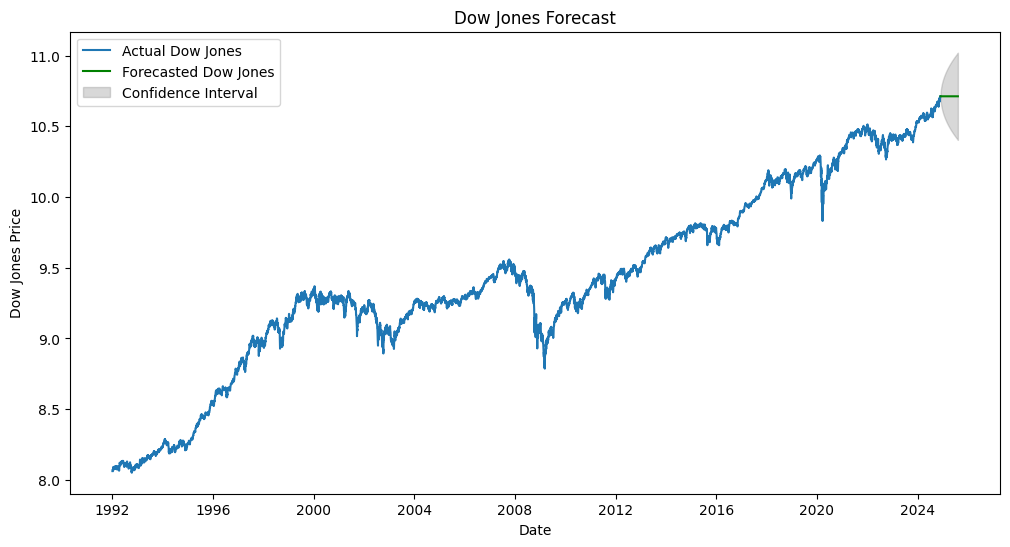

In [718]:
predicted_sp500.index = future_dates
conf_int_sp500.index = future_dates


predicted_dow.index = future_dates
conf_int_dow.index = future_dates

# Plot S&P 500 predictions
plt.figure(figsize=(12, 6))
plt.plot(sp500_data, label='Actual S&P 500')
plt.plot(predicted_sp500, label='Forecasted S&P 500', color='orange')
plt.fill_between(conf_int_sp500.index, conf_int_sp500.iloc[:, 0], conf_int_sp500.iloc[:, 1],
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.title('S&P 500 Forecast')
plt.xlabel('Date')
plt.ylabel('S&P 500 Price')
plt.legend()
plt.show()

# Plot Dow Jones predictions
plt.figure(figsize=(12, 6))
plt.plot(dowjones_data, label='Actual Dow Jones')
plt.plot(predicted_dow, label='Forecasted Dow Jones', color='green')
plt.fill_between(conf_int_dow.index, conf_int_dow.iloc[:, 0], conf_int_dow.iloc[:, 1],
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.title('Dow Jones Forecast')
plt.xlabel('Date')
plt.ylabel('Dow Jones Price')
plt.legend()
plt.show()